### Imports


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
from joblib import Parallel, delayed # Run functions in parallel
# import scipy as sc # 
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
from enum import Enum


c:\users\george\anaconda3\envs\tensor_cuda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\george\anaconda3\envs\tensor_cuda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\users\george\anaconda3\envs\tensor_cuda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Global variables

In [2]:
data_dir = '../dataset/optiver-realized-volatility-prediction/'

use_GPU = True

warnings.filterwarnings('ignore')
# pd.set_option('max_columns', 300)


### Functional Variables

In [3]:
buckets_count = 30
max_seconds_in_bucket = 600  # range 0-600 (seconds) for each observation

buckets = np.linspace(0, max_seconds_in_bucket, buckets_count, dtype=int) #  List used for binning (used as a name:lower bound of group) 
buckets = buckets[:-1]

output_dir = 'run_results/'
test_id = '2nd_attempt_feat_reduction' + str(buckets_count)
test_dir = output_dir+test_id+"/"

# Number of columns that should have a value (not nan)
nan_threshold = 15

### Helper Functions

In [4]:
# wap of 1st entry in book
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1']+ df['ask_size1'])
    return wap

# wap of 2nd entry in book
def calc_wap2(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def unique_count(series):
    return len(np.unique(series))

def read_main_csvs():
    train = pd.read_csv(data_dir + 'train.csv')
    test = pd.read_csv(data_dir + 'test.csv')
    # Create row_id to merge data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'The training set has {train.shape[0]} rows')
    return train, test

def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df

def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

def plot_importance(importance_fig, filename):
    if not os.path.exists(os.path.dirname(test_dir)):
        try:
            os.makedirs(os.path.dirname(test_dir))
        except:
            print("Could not create dir",filename)
    timestamp = datetime.datetime.now().strftime('%m-%d-%H_%M')
    importance_fig.figure.savefig(test_dir+filename+timestamp+"plot"+".png")
    
    
def save_results_to_file(filename,params,rmspe_score):
    if not os.path.exists(os.path.dirname(test_dir)):
        try:
            os.makedirs(os.path.dirname(test_dir))
        except:
            print("Could not create dir")
    timestamp = datetime.datetime.now().strftime('%m-%d-%H_%M')
    with open(test_dir+filename+timestamp+'.txt', 'w') as f:
        f.write(f'The test RMSPE is {rmspe_score} \n Hyperparams: {params}')


# Calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Early stoping, root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

# Create features for order book data (for a given stock file)
def create_bucketed_features(dataframe, aggregate_features_map):
    features = pd.DataFrame()

    for bucket_start_time in buckets:
        # Group into time buckets
        bucketed_features = dataframe[dataframe['seconds_in_bucket']
                                      .between(bucket_start_time, bucket_start_time + buckets[1] - buckets[0])].groupby(['time_id']).agg(aggregate_features_map)
        bucketed_features.columns = ['_'.join(col) for col in bucketed_features.columns]
        bucketed_features = bucketed_features.add_suffix('_' + str(bucket_start_time))
        if bucket_start_time == 0:
            features = bucketed_features
        else:
            features = features.merge(bucketed_features, how = 'outer', left_on = 'time_id', right_on = 'time_id')
    
    return features


### 2nd Attempt feature engineering

In [5]:
def group_order_book_in_time_buckets(file_path):
    dataframe = pd.read_parquet(file_path)
    
    dataframe['wap2'] = calc_wap1(dataframe)
    dataframe['price_diff'] = abs(dataframe['ask_size2'] - dataframe['bid_price2'])
    dataframe['price_spread'] = (dataframe['ask_price1'] - dataframe['bid_price1']) / ((dataframe['ask_price1'] + dataframe['bid_price1']) / 2)
    dataframe['order_size'] = dataframe['ask_size1'] * dataframe['ask_size2'] + dataframe['bid_size1'] * dataframe['bid_size2']
    
    aggregate_features_map = {
        'wap2': [np.mean],
        'price_diff': [np.mean],
        'price_spread': [np.mean],
        'order_size': [np.mean],
    }
    
        
    features = create_bucketed_features(dataframe,aggregate_features_map)
    features = features.reset_index(level=0)
    # Create row_id to merge
    stock_id = file_path.split('=')[1]
    features['row_id'] = features['time_id'].apply(lambda x: f'{stock_id}-{x}')
    features.drop(['time_id'], axis = 1, inplace = True)
    return features

# Split into time buckets within a time_id
def group_trade_book_in_time_buckets(file_path):
    dataframe = pd.read_parquet(file_path)
    dataframe['log_return'] = dataframe.groupby('time_id')['price'].apply(log_return)
    
    aggregate_features_map = {
        'log_return':[realized_volatility],
        'price':[np.mean, np.max, np.min],
        'size':[np.mean, np.max, np.min],
        'order_count':[np.mean, np.max, np.min],
    }


    features = create_bucketed_features(dataframe,aggregate_features_map)
    features = features.reset_index(level=0)
    features = features.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    features['row_id'] = features['trade_time_id'].apply(lambda x:f'{stock_id}-{x}')
    features.drop(['trade_time_id'], axis = 1, inplace = True)
    return features

# Create group stats for all stocks in each time_id
def get_group_time_id_stats(dataframe):
    group_stats = []

    for bucket in buckets:
        group_stats.append(f'wap2_mean_{bucket}')
        group_stats.append(f'trade_log_return_realized_volatility_{bucket}')



    time_id = dataframe.groupby(['time_id'])[group_stats].agg([np.mean])
    time_id.columns = ['_'.join(col) for col in time_id.columns]
    time_id = time_id.add_suffix('_' + 'time_id_groupstat')
    
    # Merge result with main dataframe
    dataframe = dataframe.merge(time_id, how = 'inner', left_on = ['time_id'], right_on = ['time_id'])
    return dataframe



### Main Control

In [6]:
def load_stock(stock_id,is_training_set):
    # Train
    if is_training_set:
        order_book_path = f"{data_dir}book_train.parquet/stock_id={str(stock_id)}"
        trade_book_path = f"{data_dir}trade_train.parquet/stock_id={str(stock_id)}"
    # Test
    else:
        order_book_path = f"{data_dir}book_test.parquet/stock_id={str(stock_id)}"
        trade_book_path = f"{data_dir}trade_test.parquet/stock_id={str(stock_id)}"
    _tmp = None
    # Create order and trade book features and merge them

    _tmp = pd.merge(group_order_book_in_time_buckets(order_book_path), group_trade_book_in_time_buckets(trade_book_path), on = ['row_id'], how = 'left')
    return _tmp
    

In [7]:
%%time

train, test = read_main_csvs()

train_stock_ids = train['stock_id'].unique()
dataframes = None
# Features engineering & binning for training set
dataframes = Parallel(n_jobs = -1, verbose = 1)(delayed(load_stock)(stock_id,is_training_set=True) for stock_id in train_stock_ids)
# for stock_id in train_stock_ids:
#     dataframes = load_stock(stock_id, is_training_set=True)
train_ = pd.concat(dataframes, ignore_index = True)

train = train.merge(train_, on = ['row_id'], how = 'left')


test_stock_ids = test['stock_id'].unique()
print(test_stock_ids)
dataframes = None
# Features engineering & binning for test set
dataframes = Parallel(n_jobs = -1, verbose = 1)(delayed(load_stock)(stock_id,is_training_set=False) for stock_id in test_stock_ids)
# for stock_id in test_stock_ids:
#     dataframes = load_stock(stock_id, is_training_set=False)
test_ = pd.concat(dataframes, ignore_index = True)

test = test.merge(test_, on = ['row_id'], how = 'left')

# Generate group stats for time_id and stock_id
 
train = get_group_time_id_stats(train)
test = get_group_time_id_stats(test)


The training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  2.7min finished


[0]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


CPU times: total: 53.6 s
Wall time: 3min 42s


In [8]:
gain_importance_list = []
split_importance_list = []



### Sanity Checks

In [9]:
len(train.index)

428932

In [10]:
train.head()

,stock_id,time_id,target,row_id,wap2_mean_0,price_diff_mean_0,price_spread_mean_0,order_size_mean_0,wap2_mean_20,price_diff_mean_20,...,wap2_mean_496_mean_time_id_groupstat,trade_log_return_realized_volatility_496_mean_time_id_groupstat,wap2_mean_517_mean_time_id_groupstat,trade_log_return_realized_volatility_517_mean_time_id_groupstat,wap2_mean_537_mean_time_id_groupstat,trade_log_return_realized_volatility_537_mean_time_id_groupstat,wap2_mean_558_mean_time_id_groupstat,trade_log_return_realized_volatility_558_mean_time_id_groupstat,wap2_mean_579_mean_time_id_groupstat,trade_log_return_realized_volatility_579_mean_time_id_groupstat
0,0,5,0.004136,0-5,1.001444,98.998630,0.000878,12575.230769,1.002227,98.998595,...,1.002369,0.000441,1.002301,0.000437,1.002176,0.000493,1.002105,0.000506,1.001957,0.000471
1,1,5,0.006340,1-5,1.001105,56.149229,0.000777,6996.250000,1.002286,50.174960,...,1.002369,0.000441,1.002301,0.000437,1.002176,0.000493,1.002105,0.000506,1.001957,0.000471
2,2,5,0.001848,2-5,1.000547,147.094908,0.000127,29341.904762,1.000538,288.777368,...,1.002369,0.000441,1.002301,0.000437,1.002176,0.000493,1.002105,0.000506,1.001957,0.000471
3,3,5,0.005300,3-5,0.999859,224.238523,0.000506,63620.666667,0.999961,305.889231,...,1.002369,0.000441,1.002301,0.000437,1.002176,0.000493,1.002105,0.000506,1.001957,0.000471
4,4,5,0.004468,4-5,1.001170,130.687324,0.001030,13616.000000,1.002041,75.682810,...,1.002369,0.000441,1.002301,0.000437,1.002176,0.000493,1.002105,0.000506,1.001957,0.000471


In [11]:
print(len(train) - len(train.dropna(thresh=nan_threshold, axis=0)))
print(len(test) - len(test.dropna()))

# drop rows (axis=0) if more than 3 columns are nan
train.dropna(inplace=True, thresh=nan_threshold, axis=0)


0
3


In [12]:

test.head()

,stock_id,time_id,row_id,wap2_mean_0,price_diff_mean_0,price_spread_mean_0,order_size_mean_0,wap2_mean_20,price_diff_mean_20,price_spread_mean_20,...,wap2_mean_496_mean_time_id_groupstat,trade_log_return_realized_volatility_496_mean_time_id_groupstat,wap2_mean_517_mean_time_id_groupstat,trade_log_return_realized_volatility_517_mean_time_id_groupstat,wap2_mean_537_mean_time_id_groupstat,trade_log_return_realized_volatility_537_mean_time_id_groupstat,wap2_mean_558_mean_time_id_groupstat,trade_log_return_realized_volatility_558_mean_time_id_groupstat,wap2_mean_579_mean_time_id_groupstat,trade_log_return_realized_volatility_579_mean_time_id_groupstat
0,0,4,0-4,1.000405,18.667011,0.000557,17396.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print(len(train.index))
train.columns

428932


Index(['stock_id', 'time_id', 'target', 'row_id', 'wap2_mean_0',
       'price_diff_mean_0', 'price_spread_mean_0', 'order_size_mean_0',
       'wap2_mean_20', 'price_diff_mean_20',
       ...
       'wap2_mean_496_mean_time_id_groupstat',
       'trade_log_return_realized_volatility_496_mean_time_id_groupstat',
       'wap2_mean_517_mean_time_id_groupstat',
       'trade_log_return_realized_volatility_517_mean_time_id_groupstat',
       'wap2_mean_537_mean_time_id_groupstat',
       'trade_log_return_realized_volatility_537_mean_time_id_groupstat',
       'wap2_mean_558_mean_time_id_groupstat',
       'trade_log_return_realized_volatility_558_mean_time_id_groupstat',
       'wap2_mean_579_mean_time_id_groupstat',
       'trade_log_return_realized_volatility_579_mean_time_id_groupstat'],
      dtype='object', length=468)

In [14]:
train = train.drop(['time_id'], axis = 1)
test = test.drop(['time_id'], axis = 1)

### Model Training

In [15]:
def train_and_evaluate(train, test):
    # Hyperparammeters (just basic)
    hyperparameters = {
        'objective': 'rmse',  
        'boosting_type': 'gbdt',
        #       'boosting_type': 'dart', # Try to solve over-specialization problem in gbdt
        #       'boosting_type': 'goss', # Goss provides a new sampling method for GBDT by separating those instances with larger gradients.
        'num_iterations': 5678, # Num_iterations specifies the number of boosting iterations (trees to build). The more trees you build the more accurate your model can be at the cost of:
        'n_estimators': 20000,#controls the number of decision trees 
        'min_data_in_leaf': 9,
        'max_bin': 75, # If you define max_bin 255 that means we can have a maximum of 255 unique values per feature. Then Small max_bin causes faster speed and large value improves accuracy.
        'num_leaves': 27,
        'max_depth': 9, # This parameter control max depth of each trained tree and will have impact on:       The best value for the num_leaves parameter     Model Performance     Training Time  Pay attention If you use a large value of max_depth, your model will likely be over fit  to the train set
        'n_jobs': -1,
        'learning_rate': 0.095, # learning_rate > 0.0Typical: 0.05.
        'feature_fraction': 0.9, # or sub_feature deals with column sampling, LightGBM will randomly select a subset of features on each iteration (tree)
        'bagging_fraction': 0.9, # you can specify the percentage of rows used per tree building iteration.
        'verbose': -1,
        # 'is_unbalance': True #One of the problems you may face in the binary classification problems is how to deal with the unbalanced datasets. Obviously, you need to balance positive/negative samples but how exactly can you do that in lightgbm      
    }
    
    if use_GPU:
        hyperparameters.update(
            {'device' : 'gpu',
            'gpu_platform_id' : 0,
            'gpu_device_id' : 0,}
        )
     
   
    # We need to drop row_id as it contains info from both time_id and stock_id and time id should be out of the features | should only be used in predictions
    x = train.drop(['row_id', 'target'], axis = 1)
    y = train['target']
    x_test = test.drop(['row_id'], axis = 1)

    x['stock_id'] = x['stock_id'].astype(int)
    x_test['stock_id'] = x_test['stock_id'].astype(int)
    
    test_predictions = np.zeros(x_test.shape[0])
    
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])

    
    kfold = KFold(n_splits = 5, random_state = 66, shuffle = True)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = hyperparameters, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 10000, 
                          early_stopping_rounds = 50, 
                          verbose_eval = 50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        test_predictions += model.predict(x_test) / 5
    
    importance_plot = lgb.plot_importance(model,max_num_features=7,figsize=(32,15))
    plot_importance(importance_plot, "feature_importance_plot")
    rmspe_score = rmspe(y, oof_predictions)
    print(f'The out of folds RMSPE is {rmspe_score}')

    return test_predictions

Training fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000508235	training's RMSPE: 0.235138	valid_1's rmse: 0.000519696	valid_1's RMSPE: 0.240849
[100]	training's rmse: 0.00048296	training's RMSPE: 0.223444	valid_1's rmse: 0.000501027	valid_1's RMSPE: 0.232197
[150]	training's rmse: 0.000467774	training's RMSPE: 0.216418	valid_1's rmse: 0.000489811	valid_1's RMSPE: 0.227
[200]	training's rmse: 0.000454786	training's RMSPE: 0.210409	valid_1's rmse: 0.000480705	valid_1's RMSPE: 0.22278
[250]	training's rmse: 0.00044435	training's RMSPE: 0.205581	valid_1's rmse: 0.000474054	valid_1's RMSPE: 0.219697
[300]	training's rmse: 0.000435502	training's RMSPE: 0.201487	valid_1's rmse: 0.000468438	valid_1's RMSPE: 0.217094
[350]	training's rmse: 0.000428791	training's RMSPE: 0.198382	valid_1's rmse: 0.000465726	valid_1's RMSPE: 0.215837
[400]	training's rmse: 0.00042356	training's RMSPE: 0.195962	valid_1's rmse: 0.000463991	valid_1's RMSPE: 0.215033
[45

[550]	training's rmse: 0.000408475	training's RMSPE: 0.188933	valid_1's rmse: 0.00046688	valid_1's RMSPE: 0.216602
[600]	training's rmse: 0.000404404	training's RMSPE: 0.18705	valid_1's rmse: 0.000467499	valid_1's RMSPE: 0.216889
Early stopping, best iteration is:
[552]	training's rmse: 0.0004082	training's RMSPE: 0.188806	valid_1's rmse: 0.000466687	valid_1's RMSPE: 0.216513
Training fold 5
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.00050798	training's RMSPE: 0.235141	valid_1's rmse: 0.000518254	valid_1's RMSPE: 0.239684
[100]	training's rmse: 0.000482483	training's RMSPE: 0.223339	valid_1's rmse: 0.000499954	valid_1's RMSPE: 0.231221
[150]	training's rmse: 0.000466879	training's RMSPE: 0.216116	valid_1's rmse: 0.000489389	valid_1's RMSPE: 0.226335
[200]	training's rmse: 0.000453651	training's RMSPE: 0.209993	valid_1's rmse: 0.000480154	valid_1's RMSPE: 0.222063
[250]	training's rmse: 0.000443596	training's RMSPE: 0.205338	valid_1's rmse: 0.00

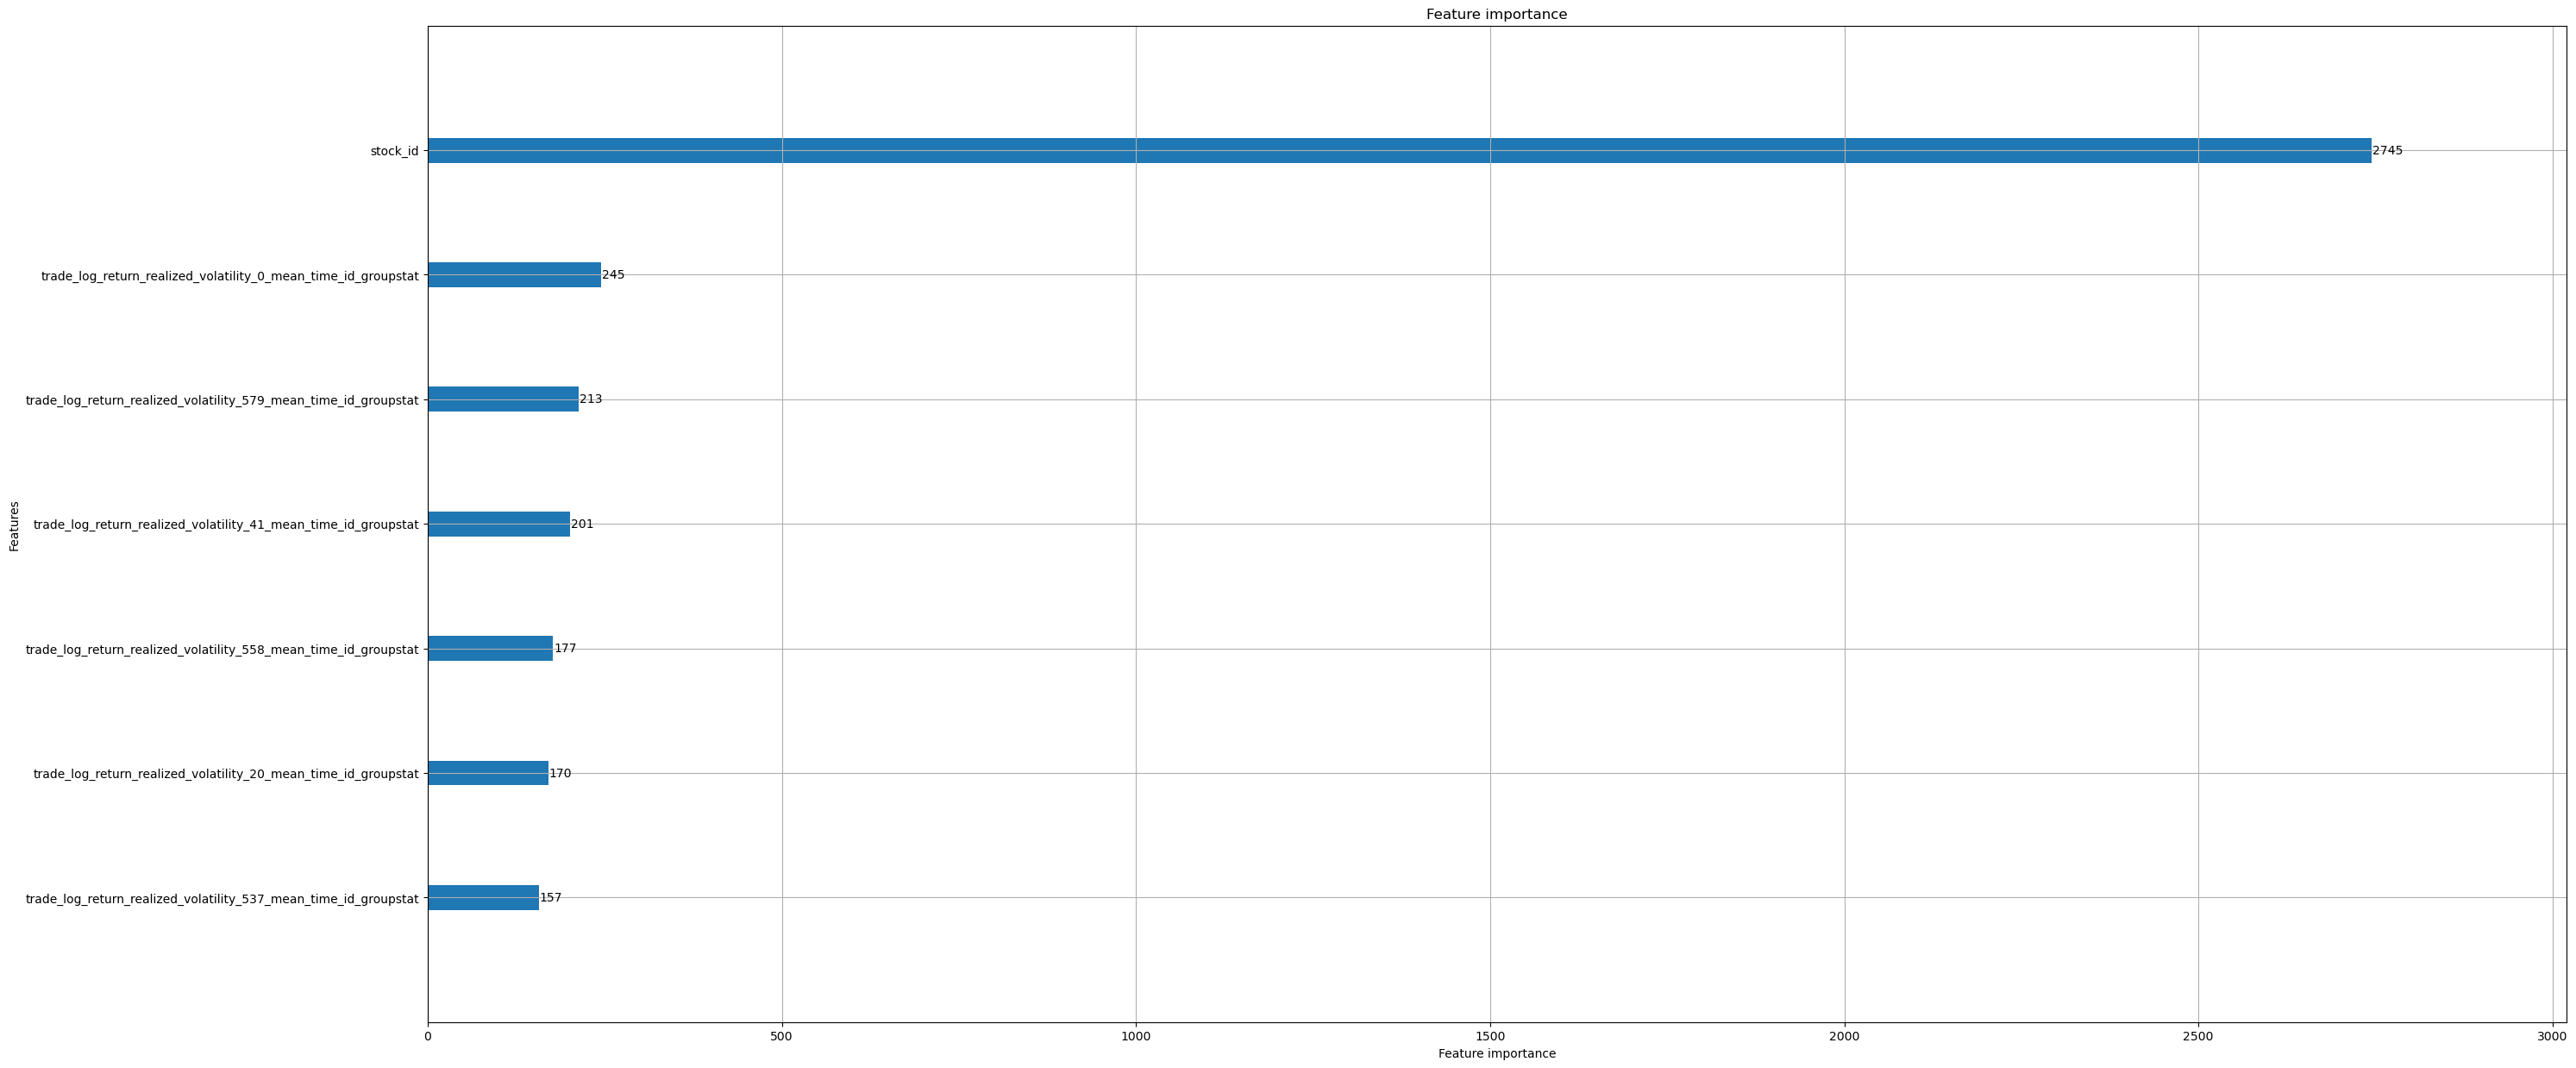

In [16]:
%%time

# Traing and evaluating
test_predictions = train_and_evaluate(train, test)

In [17]:
# Save test predictions for submission
test['target'] = test_predictions
test[['row_id', 'target']].to_csv('submission.csv',index = False)